In [27]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
# import open3d as o3d
import os
import matplotlib.pyplot as plt
# from torch_geometric.data import InMemoryDataset, Data
# from sklearn.model_selection import train_test_split, KFold

In [32]:
class IMDataset(InMemoryDataset):
    def __init__(self, raw_data_root, dataset_root, basic_features_path, ids_root, target_name, gender, transform=None, pre_transform=None):
        """
        Creates the InMemoryDataset object, convenient structure for graph training.
        :param raw_data_root: path for the input mesh data 
        :param dataset_root: path where the in memory dataset will be written
        :param basic_features_path: path of the "basic_features.csv"
        :param ids_root: path of the file saving the ids of selected samples
        :param target_name: name of the feature to be predicted
            ["sex","bmi","age","weight","height"]
        :param gender: 0 for female, 1 for male
        """
        self.ids = np.load(ids_root)
        self.raw_data_root = raw_data_root
        self.basic_features_path = basic_features_path
        self.target_name = target_name

        if not os.path.exists(dataset_root):
            os.makedirs(dataset_root)
        super(IMDataset, self).__init__(root = dataset_root, transform = transform, pre_transform = pre_transform)
        if gender == 0: #female
            self.data, self.slices = torch.load(self.processed_paths[0])
        elif gender == 1: #male
            self.data, self.slices = torch.load(self.processed_paths[1])
 
    @property
    def raw_file_names(self):
        file_names = (pd.Series(self.ids).astype(str) + ".ply").values.tolist()
        return [os.path.join(str(Path(self.raw_data_root)), file_name) for file_name in file_names]

    @property
    def processed_file_names(self):
        processed_root = self.root + "/" + self.target_name

        if not os.path.exists(processed_root):
            os.makedirs(processed_root)

        return [processed_root + "/female_dataset.pt", processed_root + "/male_dataset.pt"]
 
    def download(self):
        pass
    
    def process(self):
        """
        Combines the vertex coordinates, edge connectivity indexes and chosen target feature.
        """
        male_data_list = []
        female_data_list = []

        if self.target_name == "vat":
            cols = ["22407-2.0"]
        elif self.target_name == "asat":
            cols = ["22408-2.0"]
        elif self.target_name == "all":
            cols = ["22407-2.0", "22408-2.0"]

        features = pd.read_csv(self.basic_features_path, usecols =["eid", "31-0.0"] + cols)

        for file_path in self.raw_file_names:
            _id = int(os.path.splitext(os.path.basename(file_path))[0])
            _sex = int(features[features['eid']==_id]["31-0.0"].values[0]) #female: 0, male: 1
            _y = torch.tensor(features[features['eid']==_id][cols].values[0]).double()
            if torch.isnan(_y).any().item():
                continue
            
            _mesh = o3d.io.read_triangle_mesh(file_path)
            _vertices = torch.from_numpy(np.asarray(_mesh.vertices)).double()
            _triangles = _mesh.triangles

            """
            necessary to get the edge connectivity since the original data has only face connectivity
            we need [0,1],[1,2],[0,2],[1,0],[2,1],[2,0] instead of [0,1,2]
            including reverse as well to make the graph bi-directional
            """
            edge_list = []
            for t in _triangles:
                edge_list = edge_list + [[t[0], t[1]], [t[1], t[0]], [t[0], t[2]], [t[2], t[0]], [t[1], t[2]], [t[2], t[1]]]

            _edges = torch.from_numpy(np.unique(np.array(edge_list), axis=0)).long().permute(1, 0)

            if _sex == 0:
                female_data_list.append(Data(x=_vertices, edge_index=_edges, y=_y))
            else:
                male_data_list.append(Data(x=_vertices, edge_index=_edges, y=_y))
        
        data_female, slices_female = self.collate(female_data_list)
        data_male, slices_male = self.collate(male_data_list)
        #saves sex based datasets
        torch.save((data_female, slices_female), self.processed_paths[0])
        torch.save((data_male, slices_male), self.processed_paths[1])

In [8]:
REGISTERED_ROOT = "/vol/space/projects/ukbb/projects/silhouette/registered_25" # the path of the dir saving the .ply registered data
INMEMORY_ROOT = '/vol/space/projects/ukbb/projects/silhouette/imdataset/registered25_imdataset' # the root dir path to save all the artifacts ralated of the InMemoryDataset
FEATURES_PATH = "/vol/space/projects/ukbb/projects/silhouette/ukb668815_imaging.csv"   
IDS_PATH = "/vol/space/projects/ukbb/projects/silhouette/eids_filtered.npy"
TARGET = "all"

In [9]:
eid = np.load(IDS_PATH)

In [11]:
features = pd.read_csv(FEATURES_PATH, usecols =["eid", "31-0.0", "22407-2.0", "22408-2.0"])

In [12]:
features_female = features[features["31-0.0"]==0]
features_male = features[features["31-0.0"]==1]


In [17]:
vat_female = features_female["22407-2.0"]
vat_male = features_male["22407-2.0"]
asat_female = features_female["22408-2.0"]
asat_male = features_male["22408-2.0"]

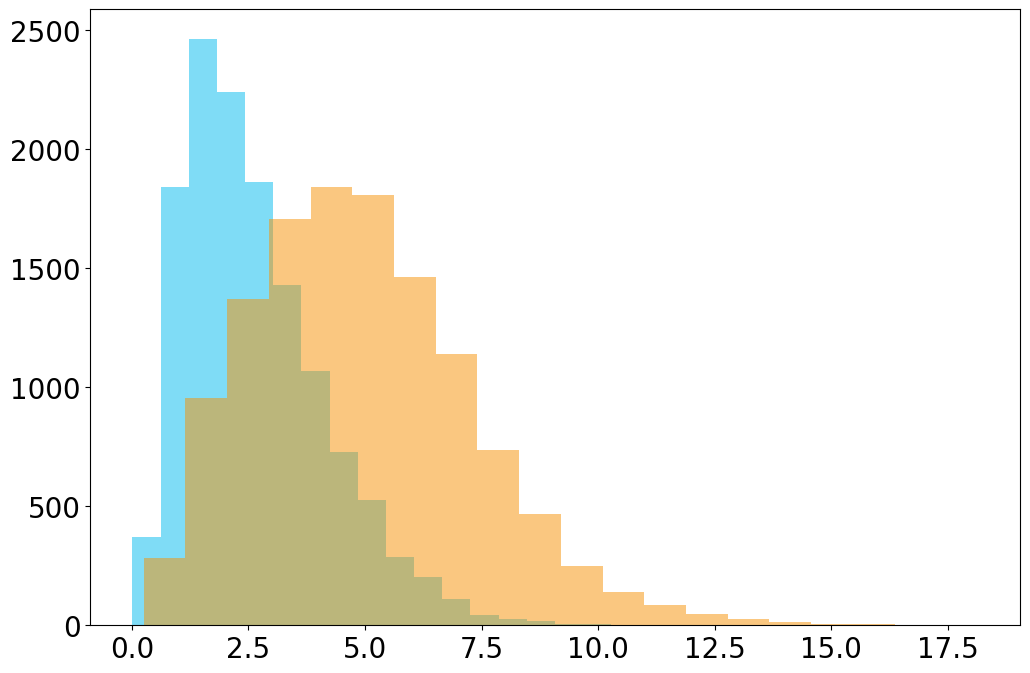

In [42]:
plt.figure(figsize=(12,8))
vat_female.hist(alpha=0.5, color="#01BAEF", grid=False, bins=20, xlabelsize=20, ylabelsize=20)
vat_male.hist(alpha=0.5, color="#F79102", grid=False,bins=20, xlabelsize=20, ylabelsize=20)
plt.savefig("vat_distributions_mal_female.pdf")

<AxesSubplot: >

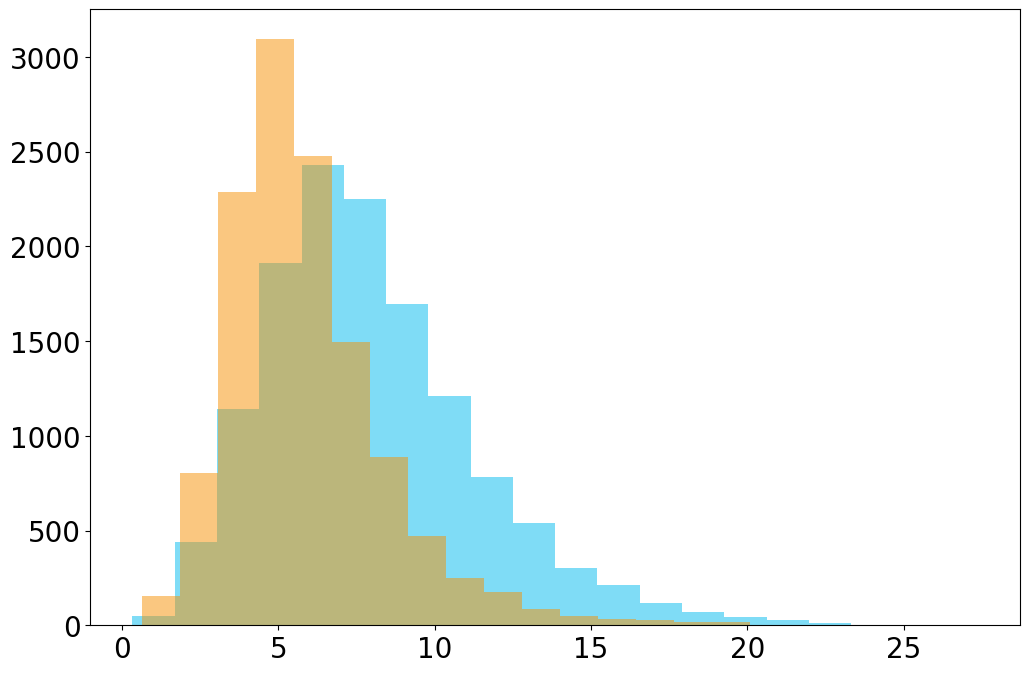

In [45]:
plt.figure(figsize=(12,8))

asat_female.hist(alpha=0.5, color="#01BAEF", grid=False, bins=20, xlabelsize=20, ylabelsize=20)
asat_male.hist(alpha=0.5, color="#F79102", grid=False, bins=20, xlabelsize=20, ylabelsize=20)

# plt.savefig("asat_distributions_mal_female.pdf")

In [15]:
our_features = features[features['eid'].isin(eid)]

In [24]:
our_features[our_features["31-0.0"] == 1]["eid"].values.shape

(12210,)

In [2]:
basic_features= pd.read_csv("/vol/aimspace/projects/ukbb/668815/basic_features.csv", usecols =["eid", "31-0.0", "21003-2.0"])

In [6]:
x = basic_features[basic_features['eid'].isin(eid)]

In [31]:
x["21003-2.0"].mean()

62.95545102379635

In [73]:
dataset_female = IMDataset(REGISTERED_ROOT, INMEMORY_ROOT, FEATURES_PATH, IDS_PATH, TARGET, 0)
dataset_male = IMDataset(REGISTERED_ROOT, INMEMORY_ROOT, FEATURES_PATH, IDS_PATH, TARGET, 1)

Processing...


KeyboardInterrupt: 

In [83]:
list(dataset_female)[6].y

tensor([2.9143, 8.2004], dtype=torch.float64)

In [84]:
list(dataset_female)[2].y

tensor([2.9346, 9.4861], dtype=torch.float64)

In [67]:
a.sum(1)

tensor([3, 7])

In [85]:
from sklearn.model_selection import train_test_split, KFold

In [86]:
test_list = list(range(20))

k = 5
kf = KFold(n_splits=k, shuffle=False)

for (train_index_female, val_index_female), (train_index_male, val_index_male) in kf.split(dev_female_x):
    train_female = [dev_female_x[i], dev_female_y[i] for i in train_index_female]
    val_female = [dev_female_x[i], dev_female_y[i] for i in val_index_female]
    train_male = [dev_male_x[i], dev_male_y[i] for i in train_index_male]
    val_male = [dev_male_x[i], dev_male_y[i] for i in val_index_male]



In [87]:
test_list 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]